In [184]:
from __future__ import unicode_literals, print_function, division
import sys
import glob
import os
import torch
import torch.nn as nn
import random
import time
import numpy as np

In [185]:
gpu_id = "2"
device = torch.device("cuda:" + gpu_id if torch.cuda.is_available() else "cpu")

In [186]:
device

device(type='cuda', index=2)

In [187]:
def findFiles(path):
    
    return glob.glob(path)

In [188]:
findFiles("../data/names/*.txt")

['../data/names/Vietnamese.txt',
 '../data/names/Spanish.txt',
 '../data/names/Scottish.txt',
 '../data/names/Russian.txt',
 '../data/names/Portuguese.txt',
 '../data/names/Polish.txt',
 '../data/names/Korean.txt',
 '../data/names/Japanese.txt',
 '../data/names/Italian.txt',
 '../data/names/Irish.txt',
 '../data/names/Greek.txt',
 '../data/names/German.txt',
 '../data/names/French.txt',
 '../data/names/English.txt',
 '../data/names/Dutch.txt',
 '../data/names/Czech.txt',
 '../data/names/Chinese.txt',
 '../data/names/Arabic.txt']

In [189]:
import unicodedata
import string

In [190]:
all_letters = string.ascii_letters + ".,;'"

In [191]:
all_letters

"abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ.,;'"

In [192]:
n_letters = len(all_letters)

In [193]:
def unicodeToAscii(s):
    
    return "".join([c for c in unicodedata.normalize("NFD", s) if unicodedata.category(c) != "Mn" and c in all_letters])

In [194]:
unicodeToAscii("Ślusàrski  ")

'Slusarski'

In [195]:
def readlines(path):
    
    with open(path) as f:
        
        data = f.read().split("\n")
        
        return [unicodeToAscii(line) for line in data if len(line) > 0]

In [196]:
from collections import defaultdict

In [305]:
all_categorys = set()
category_lines = defaultdict(lambda : list())

In [306]:
for filename in findFiles("../data/names/*.txt"):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categorys.add(category)
    lines = readlines(filename)
    
    for line in lines:
        category_lines[category].append(line)

In [307]:
n_categorys = len(all_categorys)

In [308]:
n_categorys

18

In [309]:
category_lines["Italian"][:5]

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']

In [310]:
all_categorys = list(all_categorys)

In [311]:
letter2index = defaultdict(lambda : len(letter2index))

In [312]:
category2index = defaultdict(lambda : len(category2index))

In [313]:
def lines2index(category_lines):
    data = []
    
    for category, lines in category_lines.items():
        
        category_index = category2index[category]
        
        for line in lines:
            
            lines_index = [letter2index[letter] for letter in line]
            data.append([lines_index, category_index])
    
    return data

In [314]:
data = lines2index(category_lines) # (name_length, ), (1, )

In [315]:
data = np.asarray(data)

In [316]:
data[:5]

array([[list([0, 1, 2, 3, 4, 5]), 0],
       [list([6, 7, 8, 5]), 0],
       [list([9, 4]), 0],
       [list([10, 11, 12, 13]), 0],
       [list([14, 2, 3, 5, 11]), 0]], dtype=object)

In [317]:
pad_tok = "#"
pad_tok_index = letter2index[pad_tok]

In [318]:
letter2index

defaultdict(<function __main__.<lambda>()>,
            {'N': 0,
             'g': 1,
             'u': 2,
             'y': 3,
             'e': 4,
             'n': 5,
             'T': 6,
             'r': 7,
             'o': 8,
             'L': 9,
             'P': 10,
             'h': 11,
             'a': 12,
             'm': 13,
             'H': 14,
             'V': 15,
             'D': 16,
             'B': 17,
             'i': 18,
             'A': 19,
             'c': 20,
             'C': 21,
             'p': 22,
             'G': 23,
             'K': 24,
             'M': 25,
             'Q': 26,
             'S': 27,
             'b': 28,
             's': 29,
             'l': 30,
             'q': 31,
             't': 32,
             'z': 33,
             'd': 34,
             'f': 35,
             'v': 36,
             'j': 37,
             'x': 38,
             "'": 39,
             'E': 40,
             'F': 41,
             'I': 42,
             'J': 43

In [319]:
class SimpleRNN(nn.Module):
    
    def __init__(self, vocab_size, embedding_size, hidden_size, num_layers, output_size, bidirectional_=False):
        
        super(SimpleRNN, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_size) # (input_length, batch_size, embedding_size)
        
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional_
        """
        Inputs input, h_0
            input: (input_length, batch_size, embedding_size)
            h_0: (num_layers * num_directions, batch_size, hidden_size)

        Outputs: output, h_n
        
            output: (input_length, batch_size, num_directions * hidden_size)
            h_n: (num_layers * num_directions, batch_size, hidden_size)
        """
        
        self.rnn_layer = nn.RNN(embedding_size, hidden_size, num_layers, bidirectional=self.bidirectional)
        
        self.linear = nn.Linear(2 * self.hidden_size if self.bidirectional is True else self.hidden_size, output_size)
        
        self.softmax = nn.Softmax(dim=1) # (batch_size, output_size)
        
    
    def forward(self, inputs):
        
        # inputs: (input_length, batch_size)
        
        inputs = self.embedding(inputs) # (input_length, batch_size, embedding_size)
        
        outputs, hn = self.rnn_layer(inputs)
        
        outputs = self.linear(outputs) # (input_length, batch_size, output_size)
        
        outputs = self.softmax(outputs[-1]) # (batch_size, output_size)
        
        return outputs

In [320]:
vocab_size = len(letter2index)
embedding_size = 128
hidden_size = 128
num_layers = 2
output_size = len(category2index)

In [321]:
net = SimpleRNN(vocab_size, embedding_size, hidden_size, num_layers, output_size).to(device)

In [322]:
net.modules

<bound method Module.modules of SimpleRNN(
  (embedding): Embedding(55, 128)
  (rnn_layer): RNN(128, 128, num_layers=2)
  (linear): Linear(in_features=128, out_features=18, bias=True)
  (softmax): Softmax()
)>

In [323]:
for para in net.parameters():
    
    print(para)

Parameter containing:
tensor([[-0.7256, -0.3292,  1.6658,  ..., -1.8358,  0.9066, -0.4614],
        [ 0.6432,  1.0925, -1.4965,  ..., -0.6656, -0.6227, -0.6685],
        [-0.8342,  0.2171, -1.8185,  ...,  2.1386, -0.4259,  1.0365],
        ...,
        [ 0.7563, -0.5129,  0.7199,  ..., -1.9660,  0.0978, -0.2856],
        [ 0.3793,  1.1402, -1.1903,  ..., -0.6307,  0.3732,  1.4228],
        [ 0.7739,  0.0136,  0.0107,  ...,  0.2688,  0.9036, -0.2027]],
       device='cuda:2', requires_grad=True)
Parameter containing:
tensor([[-0.0673,  0.0580,  0.0069,  ..., -0.0736,  0.0208,  0.0307],
        [ 0.0270, -0.0217,  0.0202,  ...,  0.0832, -0.0324,  0.0402],
        [ 0.0479, -0.0424,  0.0566,  ...,  0.0399, -0.0193,  0.0337],
        ...,
        [ 0.0773,  0.0219,  0.0190,  ...,  0.0607, -0.0868, -0.0544],
        [-0.0208, -0.0708,  0.0392,  ..., -0.0402, -0.0737, -0.0437],
        [ 0.0411,  0.0473, -0.0055,  ...,  0.0664, -0.0191, -0.0819]],
       device='cuda:2', requires_grad=True)


In [324]:
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(net.parameters())

In [325]:
batch_size = 8
train_order = [x for x in range(0, len(data), batch_size)]

In [326]:
def train_one_step(batch_name, batch_category):
    
    # batch_name: (batch_size, input_length)
    # batch_category: (batch_size)
    
    max_length = max(len(name) for name in batch_name)
    
    pad_name_tensor = [] # (max_length, batch_size)
    
    for j in range(max_length):
        
        pad_name_tensor.append([name[j] if len(name) > j else pad_tok_index for name in batch_name])
    
    pad_name_tensor = torch.tensor(pad_name_tensor).to(device)
    
    batch_category_tensor = torch.tensor([category for category in batch_category]).to(device)
    
    outputs = net(pad_name_tensor) # (batch_size, output_size)
    
    pred = torch.argmax(outputs, dim=1) # (batch_size, )
    
    outputs = torch.log(outputs) # (batch_size, output_size)
    
    loss = criterion(outputs, batch_category_tensor)
    
    optimizer.zero_grad()
    
    loss_value = loss.item()
    
    loss.backward()
    optimizer.step()
        
    return loss_value, torch.sum(pred == batch_category_tensor).item()

In [327]:
loss_trace = []
acc_trace = []

In [328]:
EPOCH = 50

for epoch in range(EPOCH):
    
    np.random.shuffle(data)
    
    train_loss = 0
    correct = 0
    start_time = time.time()
    
    for order in train_order:
        
        tmp_loss, is_correct = train_one_step(data[order : order+batch_size, 0], data[order : order+batch_size, 1])
        train_loss += tmp_loss
        correct += is_correct
    
    print("Epoch: {}, time: {} seconds, loss: {}, acc: {}".
          format(epoch, time.time() - start_time, train_loss / len(data), correct / len(data)))
    
    loss_trace.append(train_loss / len(data))
    acc_trace.append(correct / len(data))

Epoch: 0, time: 12.598566055297852 seconds, loss: 0.18255216086945283, acc: 0.566205041347016
Epoch: 1, time: 11.36025094985962 seconds, loss: 0.15096149361433767, acc: 0.66085483710272
Epoch: 2, time: 12.711695432662964 seconds, loss: 0.13599097160888782, acc: 0.6934342931154728
Epoch: 3, time: 12.189517498016357 seconds, loss: 0.12652774611123324, acc: 0.7187406595596294
Epoch: 4, time: 11.965976238250732 seconds, loss: 0.1182830375641966, acc: 0.7334362857427518
Epoch: 5, time: 11.688711881637573 seconds, loss: 0.11461083317447193, acc: 0.7434990535020425
Epoch: 6, time: 10.331897974014282 seconds, loss: 0.11012483463891996, acc: 0.749925276477035
Epoch: 7, time: 11.231618642807007 seconds, loss: 0.10577470491493385, acc: 0.7600378599183023
Epoch: 8, time: 12.042330503463745 seconds, loss: 0.10437949865668028, acc: 0.7634751419746937
Epoch: 9, time: 10.560599327087402 seconds, loss: 0.10059259366012105, acc: 0.7704493374514297
Epoch: 10, time: 12.978882789611816 seconds, loss: 0.099

In [329]:
index2category = {value:k for k, value in category2index.items()}

In [330]:
index2category

{0: 'Vietnamese',
 1: 'Spanish',
 2: 'Scottish',
 3: 'Russian',
 4: 'Portuguese',
 5: 'Polish',
 6: 'Korean',
 7: 'Japanese',
 8: 'Italian',
 9: 'Irish',
 10: 'Greek',
 11: 'German',
 12: 'French',
 13: 'English',
 14: 'Dutch',
 15: 'Czech',
 16: 'Chinese',
 17: 'Arabic'}

In [331]:
with torch.no_grad():
    def evaluation(name):

        # batch_name: (input_length, )

        name_tensor = torch.tensor([letter2index[letter] for letter in name]).to(device) # (input_length, )

        name_tensor = name_tensor.view(-1, 1) # (input_length, 1)

        outputs = net(name_tensor) # (1, output_size)
        
        pred = torch.argmax(outputs, dim=1) # (1, )
                
        return index2category[pred[0].item()]

In [335]:
for name in category_lines["Russian"][:20]:
    
    print(evaluation(name))

Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian
Russian


In [336]:
import matplotlib.pyplot as plt

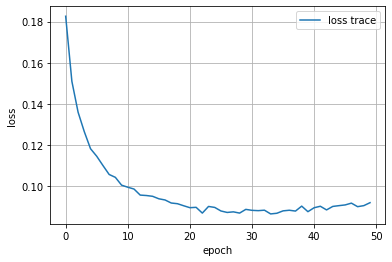

In [337]:
plt.plot(loss_trace, label="loss trace")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid()
plt.legend()

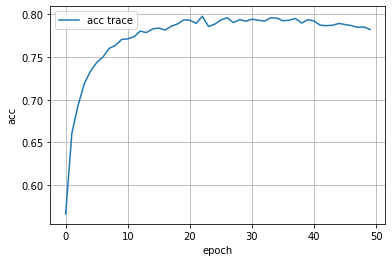

In [338]:
plt.plot(acc_trace, label="acc trace")
plt.xlabel("epoch")
plt.ylabel("acc")
plt.grid()
plt.legend()